In [2]:
from mltoolkit import *

In [3]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path

In [12]:
PATH = Path("/home/gokul/Data/CameraIdentification/train")
list(PATH.iterdir())

[PosixPath('/home/gokul/Data/CameraIdentification/train/Motorola-X'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/Motorola-Nexus-6'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/iPhone-4s'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/iPhone-6'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/HTC-1-M7'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/LG-Nexus-5x'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/Sony-NEX-7'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/Motorola-Droid-Maxx'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/Samsung-Galaxy-S4'),
 PosixPath('/home/gokul/Data/CameraIdentification/train/Samsung-Galaxy-Note3')]

In [9]:
im = Image.open(PATH/'Samsung-Galaxy-Note3/(GalaxyN3)75.jpg')

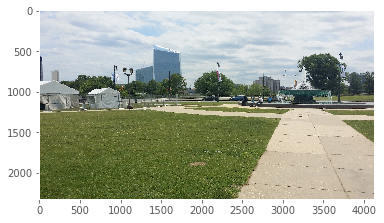

In [10]:
plt.imshow(np.asarray(im))
plt.grid(False)

# Transformations

In [13]:
random_crop = transforms.RandomCrop(512),
random_hflip = transforms.RandomHorizontalFlip(),
random_vflip = transforms.RandomVerticalFlip(),
to_tensor = transforms.ToTensor(),
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
def apply_transforms(x, sz=(512, 512)):
    """ Applies a random crop, rotation"""
    x = random_crop[0](x)
    x = random_hflip[0](x)
    x = random_vflip[0](x)
    x = to_tensor[0](x)
    x = normalize(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


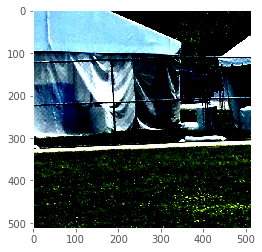

In [14]:
plt.imshow(apply_transforms(im).numpy().transpose((1, 2, 0)));
plt.grid()

In [15]:
df = folder2df(fpath=PATH)

In [16]:
df.head()

,fname,label
0,/home/gokul/Data/CameraIdentification/train/HT...,HTC-1-M7
1,/home/gokul/Data/CameraIdentification/train/HT...,HTC-1-M7
2,/home/gokul/Data/CameraIdentification/train/HT...,HTC-1-M7
3,/home/gokul/Data/CameraIdentification/train/HT...,HTC-1-M7
4,/home/gokul/Data/CameraIdentification/train/HT...,HTC-1-M7


In [11]:
# lb = LabelBinarizer()
# lb.fit(df.label)
# lb.classes_

In [17]:
train, valid = split_df(df)

# DataSet

In [18]:
class InvasiveDataset(Dataset):
    def __init__(self, df, transform=False):
        self.num_files = df.shape[0]
        self.files_path = df.fname.values
        # incase of multi class
        # self.labels = lb.transform(df.label)
        self.labels = df.label.cat.codes
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        fpath = str(self.files_path[idx])
        x = Image.open(fpath)
        x = apply_transforms(x)
        return x, y

In [19]:
train_ds = InvasiveDataset(train, transform=True)
valid_ds = InvasiveDataset(valid)

In [20]:
len(train_ds)

1978

In [21]:
len(valid_ds)

497

In [22]:
x, y = train_ds[900]
x.shape, y

(torch.Size([3, 512, 512]), 4)

In [23]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [24]:
len(train_dl) # len(train_ds) / batch_size

495

In [25]:
resnet = models.resnet34(pretrained=True)

In [26]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [27]:
# output size for last layer
len(df.label.unique())

9

# Model

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)   # .cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 9)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        # x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [29]:
model = Net()

In [30]:
x, y = next(iter(train_dl))

In [31]:
x.shape

torch.Size([4, 3, 512, 512])

In [32]:
y.shape

torch.Size([4])

In [33]:
y

tensor([1, 4, 8, 1], dtype=torch.int8)

In [34]:
# model = model.double()

In [35]:
x_features = model.top_model(x)
x_features.shape

torch.Size([4, 512, 16, 16])

In [36]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([4, 512, 1, 1])

In [37]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([4, 512])

In [38]:
y_hat = model(x)
y_hat.shape

torch.Size([4, 9])

In [39]:
y.shape

torch.Size([4])

Cross Entropy Loss expects is a class index (`0` to `C-1`, where `C` = number of classes)

In [40]:
criteria = nn.CrossEntropyLoss()
criteria(y_hat, y.long())

tensor(2.2176, grad_fn=<NllLossBackward>)

# Learning Rate Finder

In [41]:
len(list(model.parameters()))

116

In [42]:
p = list(model.parameters())[0]

In [43]:
type(p)

torch.nn.parameter.Parameter

In [44]:
p.requires_grad

False

In [45]:
parameters = filter(lambda p: p.requires_grad, model.parameters())

In [46]:
len(list(parameters))

8

In [47]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [48]:
def save_model(m, path):
    torch.save(m.state_dict(), path)

In [49]:
def load_model(m, path):
    m.load_state_dict(torch.load(path))

In [53]:
def lr_range_finder(model, train_dl, loss_criteria=F.cross_entropy
                    lr_low=1e-5, lr_high=1, epochs=4):
    losses = []
    # save the model so that
    p = PATH/"models/tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low) / iterations
    lrs = [lr_low + (i * delta) for i in range(iterations)]
    # set model in train
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x  # .cuda().float()
            y = y  # .cuda().float().unsqueeze(1)
            out = model(x)
            loss = loss_criteria(out, y.long())
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind += 1

    load_model(model, str(p))
    return lrs, losses

In [55]:
model = Net() # .cuda()
lrs, losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                              lr_high=0.1, epochs=1)

In [114]:
plt.plot(lrs, losses)
plt.show()